In [1]:
#in this research, we have collected a top list of 100 crypto assets based on market cap from the cryptocompare API.
#we have also used this top list to get daily historical data of all the crypto assets. This data is in the "/Data folder".

#the first purpose of our research will be to find out the optimal point to buy alt coins based on the position of BTC,
#this research is purely technical in nature.

In [2]:
#we first import pandas, pandas is used for data exploration and manipulation
import pandas as pd
# Set the maximum number of rows to display
pd.set_option('display.max_rows', 700)

In [3]:
#read top list data
top_list_data = pd.read_csv('Data/top_coins.csv')

In [4]:
print("First 10 rows:")
print(top_list_data.head(10))

First 10 rows:
   Name     MaxSupply
0   BTC  2.100000e+07
1   ETH -1.000000e+00
2   XRP  1.000000e+11
3  USDT -1.000000e+00
4   SOL -1.000000e+00
5   BNB  1.000000e+08
6  DOGE -1.000000e+00
7   ADA  4.500000e+10
8   SUI -1.000000e+00
9  USDC -1.000000e+00


In [5]:
#now, load historical data and aggregate daily to weekly. start with BTC first.

In [6]:
historical_data = pd.read_csv('Data/historical_prices.csv')

In [7]:
#this dataframe above contains OHLCV daily historical data of top crypto assets from the prev 2000days
#it is arranged in descending order, and as such, printing the head or describing it will not be necessary

In [8]:
print("Earliest date:", pd.to_datetime(historical_data['Time'].min(), unit='s'))
print("Latest date:", pd.to_datetime(historical_data['Time'].max(), unit='s'))

Earliest date: 2019-06-25 00:00:00
Latest date: 2024-12-15 00:00:00


In [9]:
#now, lets start with printing the daily chart for BTC and then aggregrate it into weekly

In [10]:
import matplotlib.pyplot as plt

In [11]:
# Load BTC data
btc_historical_data = historical_data[historical_data['Coin'] == 'BTC'].copy()

In [12]:
# Convert Unix timestamp to datetime
btc_historical_data['Date'] = pd.to_datetime(btc_historical_data['Time'], unit='s')

In [13]:
btc_historical_data.head()

,Coin,Time,High,Low,Open,Close,VolumeFrom,VolumeTo,Date
0,BTC,1561420800,11778.22,10992.37,11035.74,11740.34,84123.73,9.539626e+08,2019-06-25
1,BTC,1561507200,13826.76,11679.10,11740.34,12913.28,211449.88,2.685872e+09,2019-06-26
2,BTC,1561593600,13314.05,10335.34,12913.28,11154.09,202428.68,2.345027e+09,2019-06-27
3,BTC,1561680000,12433.00,10772.75,11154.09,12355.06,120700.97,1.408439e+09,2019-06-28
4,BTC,1561766400,12362.90,11352.27,12355.06,11884.10,81875.16,9.685168e+08,2019-06-29


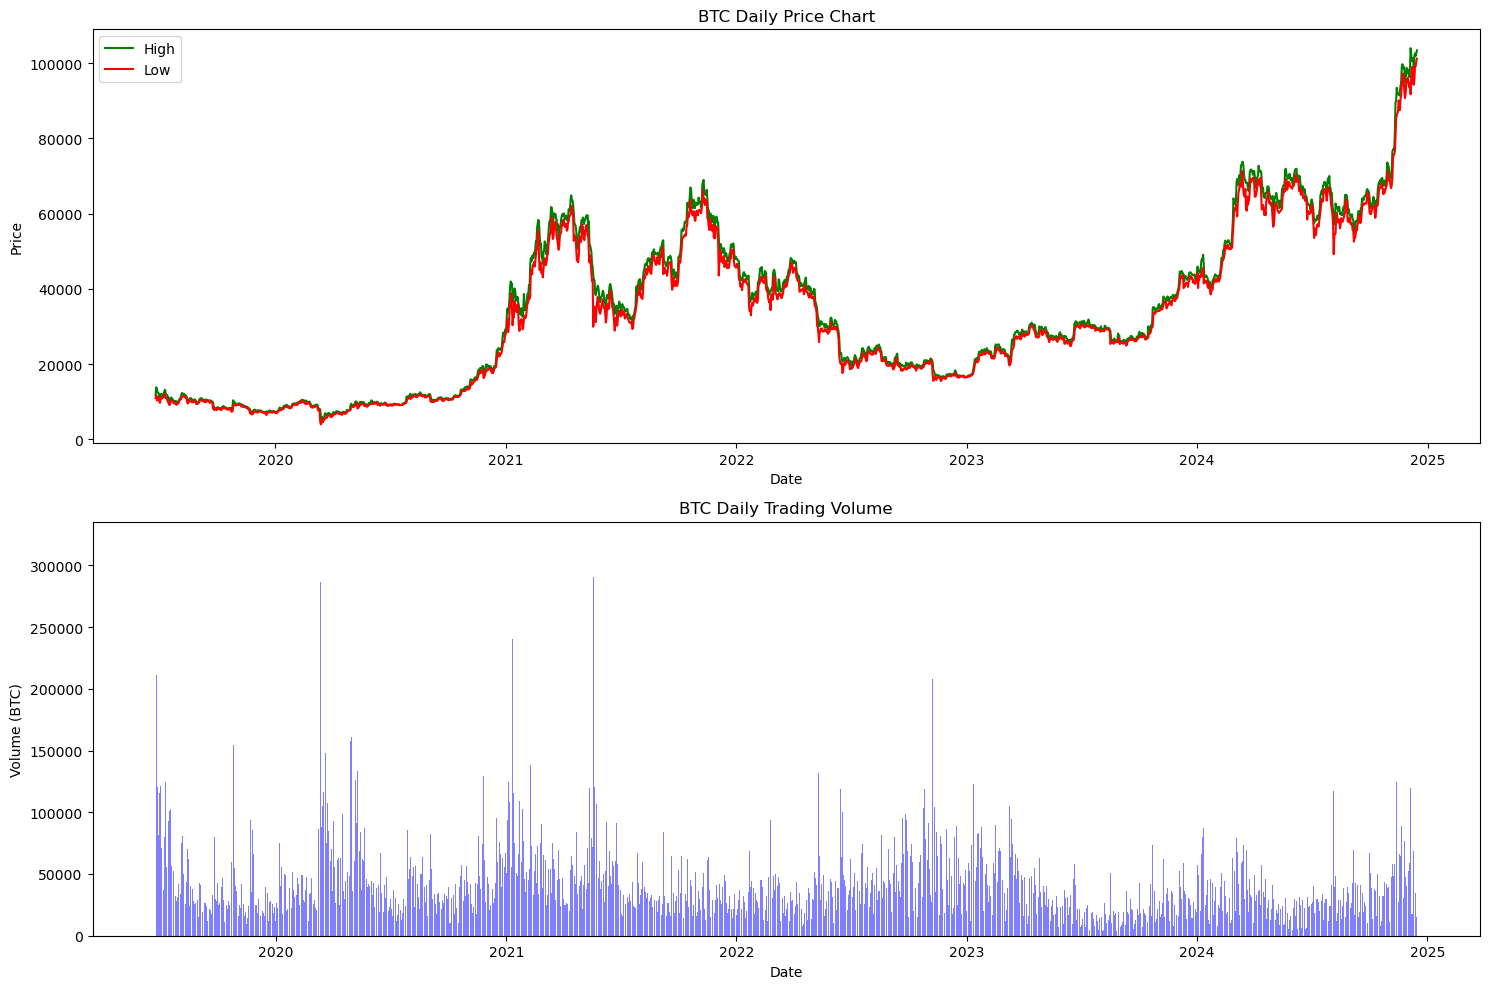

In [14]:
# Create a figure with multiple subplots
plt.figure(figsize=(15,10))
# Price subplot
plt.subplot(2,1,1)
plt.plot(btc_historical_data['Date'], btc_historical_data['High'], label='High', color='green')
plt.plot(btc_historical_data['Date'], btc_historical_data['Low'], label='Low', color='red')
plt.title('BTC Daily Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Volume subplot
plt.subplot(2,1,2)
plt.bar(btc_historical_data['Date'], btc_historical_data['VolumeFrom'], color='blue', alpha=0.5)
plt.title('BTC Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume (BTC)')

plt.tight_layout()
plt.show()


In [15]:
#now, we begin the process of trying to find the best point to buy altcons

In [16]:
import numpy as np

In [17]:
# Function to calculate future returns over different timeframes

'''
for each day in our days of available data of a coin, this below function
calculates what the return would have been if you had bought
on that day and held for 7, 14, 30, or 90 days.
    
So if we look at a specific day, let's say January 1st:

return_7d shows the percentage return if you bought on Jan 1st and sold on Jan 8th
return_14d shows the return if you bought on Jan 1st and sold on Jan 15th
return_30d shows the return if you bought on Jan 1st and sold on Jan 31st
return_90d shows the return if you bought on Jan 1st and sold on Apr 1st

'''

def calculate_future_returns(df, timeframes=[7, 14, 30, 90]):
    results = {}
    for days in timeframes:
        # Calculate future price change percentage
        df[f'return_{days}d'] = df['Close'].pct_change(periods=days).shift(-days) * 100
    return df

In [18]:
# Let's use it with some sample data
#btc_data = historical_data[historical_data['Coin'] == 'BTC'].copy()
#btc_data['Date'] = pd.to_datetime(btc_data['Time'], unit='s')
#result = calculate_future_returns(btc_data)

# Look at some results
#print("Sample of results:")
#print(result[['Date','Open', 'Close', 'return_7d', 'return_30d', 'return_90d']].head(10))

In [19]:
# Apply to each coin
coins = historical_data['Coin'].unique()
all_coins_analysis = {}

In [20]:
#we apply this function to all our coins except BTC
for coin in coins:
    if coin != 'BTC':  # Skip BTC as it's our reference
        coin_data = historical_data[historical_data['Coin'] == coin].copy()
        coin_data = calculate_future_returns(coin_data)
        all_coins_analysis[coin] = coin_data

In [21]:
'''
we get BTC data and create moving averages, which are popular indicators
MA20: Creates 20-day moving average (popular short-term trend indicator)
MA50: Creates 50-day moving average (popular medium-term trend indicator)
'rolling(window=20)' looks at last 20 days for each calculation
Example: MA20 for day 21 is average of closing prices from day 1 to 20
'''

# Get BTC data
btc_data = historical_data[historical_data['Coin'] == 'BTC'].copy()
btc_data['BTC_Price_MA20'] = btc_data['Close'].rolling(window=20).mean()
btc_data['BTC_Price_MA50'] = btc_data['Close'].rolling(window=50).mean()


In [24]:
'''
the below function analyzes BTC data relative to altcoin data
it combines alt coin data with BTC metrics using timestamp as key
'_BTC' suffix added to BTC columns to avoid name conflicts
Example: 'Close' (alt coin price) vs 'Close_BTC' (BTC price)
'''
# Function to analyze alt coin performance relative to BTC
def analyze_relative_to_btc(alt_coin_data, btc_data):
    # Merge BTC metrics with alt coin data
    merged = pd.merge(alt_coin_data, btc_data[['Time', 'Close', 'BTC_Price_MA20', 'BTC_Price_MA50']], 
                     on='Time', suffixes=('', '_BTC'))
    
    '''
    below function Shows how alt coin price compares to BTC price
    Rising ratio means alt coin outperforming BTC
    Falling ratio means BTC outperforming alt coin
    '''
    merged['Price_Ratio_to_BTC'] = merged['Close'] / merged['Close_BTC']* 100
    
    '''
    below function Shows how far BTC price is from its 20-day moving average
    Positive: BTC above MA20 (potential uptrend)
    Negative: BTC below MA20 (potential downtrend)
    Higher absolute values mean stronger trends
    '''
    merged['BTC_Distance_From_MA20'] = ((merged['Close_BTC'] - merged['BTC_Price_MA20']) / merged['BTC_Price_MA20']) * 100
    
    return merged

In [28]:
#lets use an example to test out the above function
# Example usage
btc_data = historical_data[historical_data['Coin'] == 'BTC'].copy()
eth_data = historical_data[historical_data['Coin'] == 'ETH'].copy()

# Calculate BTC metrics
btc_data['BTC_Price_MA20'] = btc_data['Close'].rolling(window=20).mean()
btc_data['BTC_Price_MA50'] = btc_data['Close'].rolling(window=50).mean()

# Analyze ETH relative to BTC
result = analyze_relative_to_btc(eth_data, btc_data)

# Show sample result
print(result[['Time', 'Close', 'Close_BTC', 'Price_Ratio_to_BTC', 'BTC_Distance_From_MA20']].head(30))

          Time   Close  Close_BTC  Price_Ratio_to_BTC  BTC_Distance_From_MA20
0   1561420800  316.17   11740.34            2.693023                     NaN
1   1561507200  334.45   12913.28            2.589969                     NaN
2   1561593600  293.91   11154.09            2.634998                     NaN
3   1561680000  309.62   12355.06            2.506018                     NaN
4   1561766400  317.78   11884.10            2.673993                     NaN
5   1561852800  290.55   10769.05            2.698010                     NaN
6   1561939200  294.14   10591.87            2.777036                     NaN
7   1562025600  291.60   10844.13            2.689012                     NaN
8   1562112000  302.18   11981.61            2.522032                     NaN
9   1562198400  282.93   11156.52            2.536006                     NaN
10  1562284800  288.02   10993.25            2.619971                     NaN
11  1562371200  287.97   11248.94            2.559975           

In [31]:
def find_optimal_entry_conditions(merged_data):
    # Group by different BTC conditions
     # This dictionary defines different market conditions we want to test
    conditions = {
        # Condition 1: When BTC price is below its 20-day moving average
        'BTC_Below_MA20': merged_data['Close_BTC'] < merged_data['BTC_Price_MA20'],
        'BTC_Above_MA50': merged_data['Close_BTC'] > merged_data['BTC_Price_MA50'],
        'BTC_In_Uptrend': (merged_data['BTC_Price_MA20'] > merged_data['BTC_Price_MA50']),
        'BTC_Major_Dip': merged_data['BTC_Distance_From_MA20'] < -10,  # BTC more than 10% below MA20
        # Add more conditions as needed
    }
    
    results = {}
    for condition_name, condition in conditions.items():
        # Calculate average returns under each condition
        # For each condition, we look at different holding periods
        for days in [7, 14, 30, 90]:
            # merged_data[condition] filters rows where condition is True
            # f'return_{days}d' accesses the future returns we calculated earlier
            avg_return = merged_data[condition][f'return_{days}d'].mean()
            # Store result with key like 'BTC_Below_MA20_7d'
            results[f'{condition_name}_{days}d'] = avg_return
            
    return results

In [38]:
#lets test the above function
#we should see something like below as our results:
#BTC_Below_MA20_7d: 5.23%   # Average 7-day return when buying ETH while BTC is below MA20
#BTC_Below_MA20_14d: 8.45%  # Average 14-day return when buying ETH while BTC is below MA20
#BTC_Below_MA20_30d: 12.67% # Average 30-day return when buying ETH while BTC is below MA20
#BTC_Below_MA20_90d: 25.89% # Average 90-day return when buying ETH while BTC is below MA20


In [39]:
btc_data = historical_data[historical_data['Coin'] == 'BTC'].copy()
eth_data = historical_data[historical_data['Coin'] == 'ETH'].copy()

# Calculate BTC metrics
btc_data['BTC_Price_MA20'] = btc_data['Close'].rolling(window=20).mean()
btc_data['BTC_Price_MA50'] = btc_data['Close'].rolling(window=50).mean()
eth_data = calculate_future_returns(eth_data)  # Calculate future returns

#  Merge and analyze
merged = analyze_relative_to_btc(eth_data, btc_data)
results = find_optimal_entry_conditions(merged)

print("Results:")
for condition_timeframe, avg_return in results.items():
    print(f"{condition_timeframe}: {avg_return:.2f}%")

Results:
BTC_Below_MA20_7d: 0.86%
BTC_Below_MA20_14d: 1.70%
BTC_Below_MA20_30d: 3.22%
BTC_Below_MA20_90d: 13.69%
BTC_Above_MA50_7d: 3.23%
BTC_Above_MA50_14d: 5.74%
BTC_Above_MA50_30d: 11.33%
BTC_Above_MA50_90d: 35.34%
BTC_In_Uptrend_7d: 2.42%
BTC_In_Uptrend_14d: 4.92%
BTC_In_Uptrend_30d: 10.05%
BTC_In_Uptrend_90d: 34.11%
BTC_Major_Dip_7d: 1.14%
BTC_Major_Dip_14d: 2.40%
BTC_Major_Dip_30d: -1.20%
BTC_Major_Dip_90d: 18.09%


In [ ]:
#from the above results, we can see that buying ETH when BTC moving average
#is above 50 and holding for 90days gave the best returns

# visualization

In [ ]:
#lets try to visualizing BTC's influence on other coins

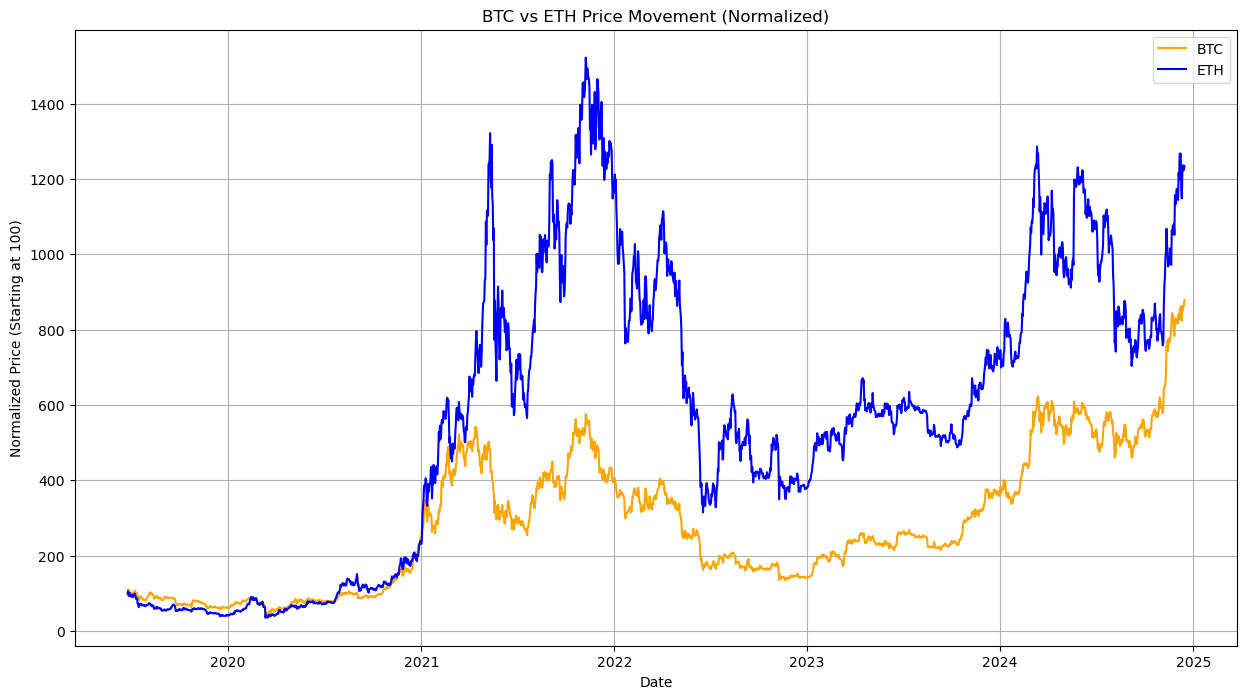

In [45]:
def plot_btc_vs_alt(alt_coin_name):
    # Get data for both coins
    btc_data = historical_data[historical_data['Coin'] == 'BTC'].copy()
    alt_data = historical_data[historical_data['Coin'] == alt_coin_name].copy()
    
    # Convert timestamps to dates
    btc_data['Date'] = pd.to_datetime(btc_data['Time'], unit='s')
    alt_data['Date'] = pd.to_datetime(alt_data['Time'], unit='s')
    
    # Normalize prices to start at 100 for easy comparison
    btc_data['Normalized'] = btc_data['Close'] / btc_data['Close'].iloc[0] * 100
    alt_data['Normalized'] = alt_data['Close'] / alt_data['Close'].iloc[0] * 100
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    plt.plot(btc_data['Date'], btc_data['Normalized'], label='BTC', color='orange')
    plt.plot(alt_data['Date'], alt_data['Normalized'], label=alt_coin_name, color='blue')
    
    plt.title(f'BTC vs {alt_coin_name} Price Movement (Normalized)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price (Starting at 100)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_btc_vs_alt('ETH')  # Replace 'ETH' with any alt coin you want to compare

In [46]:
#visualising btc moving averages:

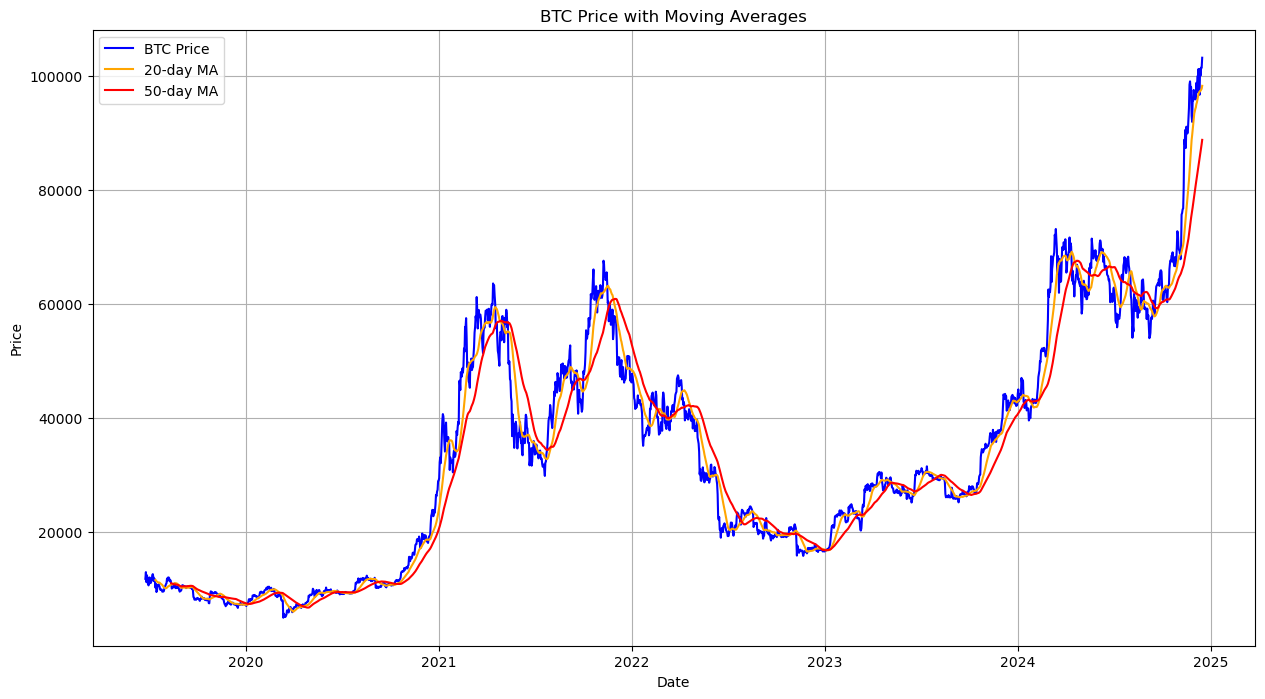

In [54]:
# Prepare BTC data
btc_data = historical_data[historical_data['Coin'] == 'BTC'].copy()
btc_data['Date'] = pd.to_datetime(btc_data['Time'], unit='s')
btc_data['BTC_Price_MA20'] = btc_data['Close'].rolling(window=20).mean()
btc_data['BTC_Price_MA50'] = btc_data['Close'].rolling(window=50).mean()

# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(btc_data['Date'], btc_data['Close'], label='BTC Price', color='blue')
plt.plot(btc_data['Date'], btc_data['BTC_Price_MA20'], label='20-day MA', color='orange')
plt.plot(btc_data['Date'], btc_data['BTC_Price_MA50'], label='50-day MA', color='red')
plt.title('BTC Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
import seaborn as sns


In [59]:
# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame([
    {'condition': 'BTC Below MA20', '7d': 0.86, '14d': 1.70, '30d': 3.22, '90d': 13.69},
    {'condition': 'BTC Above MA50', '7d': 3.23, '14d': 5.74, '30d': 11.33, '90d': 35.34},
    {'condition': 'BTC In Uptrend', '7d': 2.42, '14d': 4.92, '30d': 10.05, '90d': 34.11},
    {'condition': 'BTC Major Dip', '7d': 1.14, '14d': 2.40, '30d': -1.20, '90d': 18.09}
])

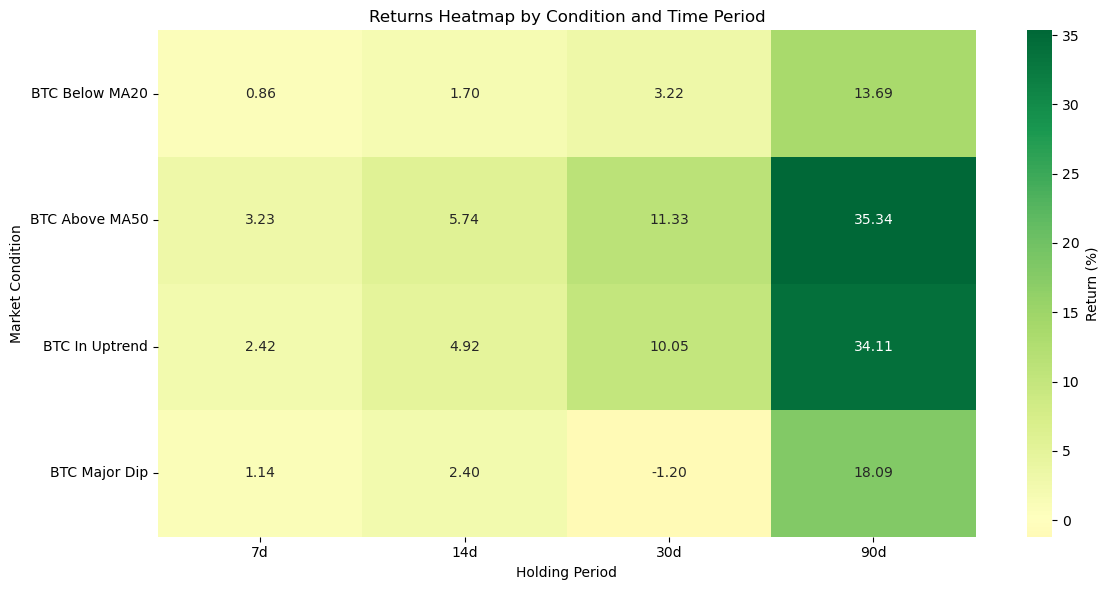

In [65]:
# 2. Heatmap of Returns
plt.figure(figsize=(12, 6))
data_for_heatmap = results_df.set_index('condition')
sns.heatmap(data_for_heatmap, 
            annot=True, 
            fmt='.2f',
            cmap='RdYlGn',
            center=0,
            cbar_kws={'label': 'Return (%)'})
plt.title('Returns Heatmap by Condition and Time Period')
plt.ylabel('Market Condition')
plt.xlabel('Holding Period')
plt.tight_layout()
plt.show()
